In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from model_settings import ms
from df_collector import df_collector
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
root = Path().resolve().parent.parent
df_collector.root = root
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}")


##################
# training start #
##################

Thu Nov  7 12:39:30 2024


In [2]:
data = df_collector.cboe_spx_asians()
pricename = [f for f in data.columns if f.find('_price')!=-1 and f.find('spot_')==-1 and f.find('strike_')==-1][0]
filetag = f'cboe spx {pricename[:pricename.find('_',0)]}'
data = data[data[pricename]<data['spot_price']]
data = data[data[pricename]>data['spot_price']*0.01].reset_index(drop=True)
og_count = data.shape[0]
print(f'collected {pricename[:pricename.find('_',0)]} options')
data

collected asian options


,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,calculation_date,kappa,theta,rho,eta,v0,date,asian_price
0,3959.00000,1979.00000,7,1.00000,7,0,geometric,call,0.04000,0.00000,2023-03-16 16:04:07.216,3.01820,0.09748,-0.61319,2.47832,0.04361,2023-03-16,1980.12150
1,3959.00000,1979.00000,7,1.00000,7,0,arithmetic,call,0.04000,0.00000,2023-03-16 16:04:07.216,3.01820,0.09748,-0.61319,2.47832,0.04361,2023-03-16,1980.39681
2,3959.00000,2968.75000,7,1.00000,7,0,geometric,call,0.04000,0.00000,2023-03-16 16:04:07.216,3.01820,0.09748,-0.61319,2.47832,0.04361,2023-03-16,991.13047
3,3959.00000,2968.75000,7,1.00000,7,0,arithmetic,call,0.04000,0.00000,2023-03-16 16:04:07.216,3.01820,0.09748,-0.61319,2.47832,0.04361,2023-03-16,991.40578
4,3959.00000,4948.25000,7,1.00000,7,0,geometric,put,0.04000,0.00000,2023-03-16 16:04:07.216,3.01820,0.09748,-0.61319,2.47832,0.04361,2023-03-16,986.85159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656642,5813.50000,5813.00000,84,1.00000,84,0,arithmetic,put,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,2024-10-15,71.36106
656643,5813.50000,7266.50000,84,1.00000,84,0,geometric,put,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,2024-10-15,1417.10275
656644,5813.50000,7266.50000,84,1.00000,84,0,arithmetic,put,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,2024-10-15,1413.68702
656645,5813.50000,8720.00000,84,1.00000,84,0,geometric,put,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,2024-10-15,2857.28188


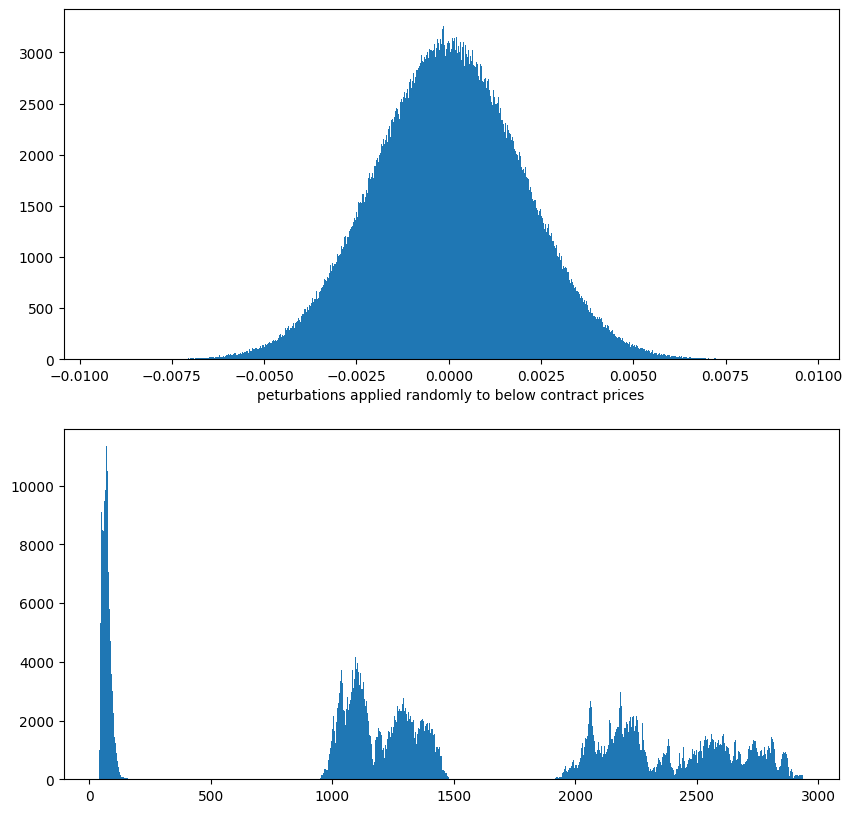

In [3]:
data = data[data[pricename]<data['spot_price']]
data = data[data[pricename]>data['spot_price']*0.01].reset_index(drop=True)

data['observed_price'] = data[pricename].apply(lambda x: max(x + np.random.normal(scale=0.002),0) if x > 0 else 0)
data = data[data['observed_price']>0]

p = data[pricename]-data['observed_price']
plotprices = data['observed_price']

fig,axs = plt.subplots(2,figsize=(10,10))
axs[0].hist(p,bins=int(len(p)**0.5))
axs[0].set_xlabel('peturbations applied randomly to below contract prices')
axs[1].hist(plotprices,bins=int(len(plotprices)**0.5))
plt.show()

# training procedure

In [4]:
from convsklearn import convsklearn
trainer = convsklearn()
help(trainer)
print('instance variables:')
trainer.__dict__

Help on convsklearn in module convsklearn.convsklearn object:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object

instance variables:


{'raw_data': Empty DataFrame
 Columns: []
 Index: [],
 'dataset': Empty DataFrame
 Columns: []
 Index: [],
 'target_name': 'observed_price',
 'excluded_features': ['barrier_price',
  'asian',
  'observed_price',
  'outin',
  'updown',
  'n_fixings'],
 'numerical_features': [],
 'categorical_features': [],
 'feature_set': [],
 'n_features': 0,
 'development_dates': {},
 'test_dates': {},
 'train_data': {},
 'test_data': {},
 'train_X': {},
 'train_y': {},
 'test_X': {},
 'test_y': {},
 'preprocessor': None,
 'pipeline': None,
 'model': None,
 'model_fit': None,
 'dnn_runtime': 0,
 'numerical_scaler': StandardScaler()}

In [5]:
trainer.load_data(data)
trainer.__dict__
trainer.dataset

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,calculation_date,kappa,theta,rho,eta,v0,date,asian_price,observed_price
0,3959.00000,1979.00000,7,1.00000,7,0,geometric,call,0.04000,0.00000,2023-03-16 16:04:07.216,3.01820,0.09748,-0.61319,2.47832,0.04361,2023-03-16,1980.12150,1980.12192
1,3959.00000,1979.00000,7,1.00000,7,0,arithmetic,call,0.04000,0.00000,2023-03-16 16:04:07.216,3.01820,0.09748,-0.61319,2.47832,0.04361,2023-03-16,1980.39681,1980.39751
2,3959.00000,2968.75000,7,1.00000,7,0,geometric,call,0.04000,0.00000,2023-03-16 16:04:07.216,3.01820,0.09748,-0.61319,2.47832,0.04361,2023-03-16,991.13047,991.13113
3,3959.00000,2968.75000,7,1.00000,7,0,arithmetic,call,0.04000,0.00000,2023-03-16 16:04:07.216,3.01820,0.09748,-0.61319,2.47832,0.04361,2023-03-16,991.40578,991.40664
4,3959.00000,4948.25000,7,1.00000,7,0,geometric,put,0.04000,0.00000,2023-03-16 16:04:07.216,3.01820,0.09748,-0.61319,2.47832,0.04361,2023-03-16,986.85159,986.85170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656642,5813.50000,5813.00000,84,1.00000,84,0,arithmetic,put,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,2024-10-15,71.36106,71.35989
656643,5813.50000,7266.50000,84,1.00000,84,0,geometric,put,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,2024-10-15,1417.10275,1417.10494
656644,5813.50000,7266.50000,84,1.00000,84,0,arithmetic,put,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,2024-10-15,1413.68702,1413.68746
656645,5813.50000,8720.00000,84,1.00000,84,0,geometric,put,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,2024-10-15,2857.28188,2857.27972


## preprocessing

In [6]:
dates = pd.Series(np.sort(data['date'].unique()))
dates

0      2023-03-16
1      2023-03-17
2      2023-03-20
3      2023-03-21
4      2023-03-22
          ...    
394    2024-10-09
395    2024-10-10
396    2024-10-11
397    2024-10-14
398    2024-10-15
Length: 399, dtype: object

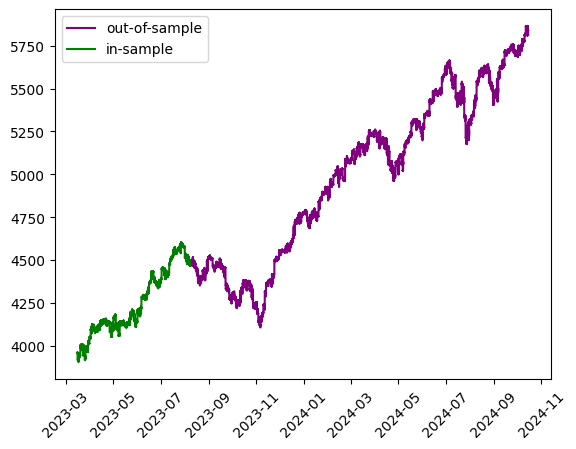

In [7]:
development_dates = dates[:100]
test_dates = dates[~dates.isin(development_dates)]
trainer.preprocess_data(development_dates,test_dates)

## training

In [8]:
trainer.run_dnn()


training on 172437 samples...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 23.878990650177002


In [9]:
print('instance varianbles:')
trainer.__dict__

instance varianbles:


{'raw_data':         spot_price  strike_price  days_to_maturity  n_fixings  \
 0       3959.00000    1979.00000                 7    1.00000   
 1       3959.00000    1979.00000                 7    1.00000   
 2       3959.00000    2968.75000                 7    1.00000   
 3       3959.00000    2968.75000                 7    1.00000   
 4       3959.00000    4948.25000                 7    1.00000   
 ...            ...           ...               ...        ...   
 656642  5813.50000    5813.00000                84    1.00000   
 656643  5813.50000    7266.50000                84    1.00000   
 656644  5813.50000    7266.50000                84    1.00000   
 656645  5813.50000    8720.00000                84    1.00000   
 656646  5813.50000    8720.00000                84    1.00000   
 
         fixing_frequency  past_fixings averaging_type     w  risk_free_rate  \
 0                      7             0      geometric  call         0.04000   
 1                      7         

In [10]:
trainer.model_fit

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'fixing_frequency',
                                                                                        'past_fixings',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0',
                                                                                        'asian_price']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['averaging_type',
                                                                                        'w'])])),
                                                     ('regressor',
                                                      MLPRegressor(alpha=0.01,
                                                                   hidden_layer_sizes=(15,
                                                                                       15),
                                                                   learning_rate='adaptive',
                                                                   learning_rate_init=0.1,
                                                                   max_iter=500,
                                                                   solver='sgd',
                                                                   warm_start=True))]),
                           transformer=StandardScaler())

### initial test

In [11]:
train_test = trainer.test_prediction_accuracy()


in sample:
     RMSE: 2.092445277428854
     MAE: 1.396501828574828

out of sample:
     RMSE: 193.3323374309201
     MAE: 100.28698684365115


## saving

In [12]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    joblib.dump(trainer.__dict__,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")

execute the command 'save_model()' to save the following model: 2024_11_07 124002946108 cboe spx asian

cpu: 32.44743609428406
